# Key observations and analysis

During previous vLLM Qwen tests, I found that NUMA alignment for the VLLM::EngineCore process had a greater impact on performance than that of the VLLM::Worker_TP processes. The key difference between the best- and worst-case scenarios is that, in the worst cases, the VLLM::EngineCore process migrated across CPU cores spanning 2 NUMA nodes, whereas in the best-case scenarios it remained confined to CPU cores within a single NUMA node. In contrast, the VLLM::Worker_TP processes migrated across NUMA nodes in both scenarios.

This reminded me to review and map [the vLLM instance architecture](https://docs.vllm.ai/en/latest/design/arch_overview/#process-count-summary) and traffic to the NUMA topology in order to identify the real performance bottlenecks and prioritize [optimization efforts.](https://docs.vllm.ai/en/latest/configuration/optimization/#cpu-resources-for-gpu-deployments) 

**Notes**: the API Server and EngineCore are combined as they have a 1:1 relationship in this setup.

![NUMA1](images/bottlenecks.png)

A vLLM instance involves five primary types of traffic summarized as follows:


|   | Traffic                    | From → To              | Purpose                                                                           | Nature                                                       |
| - | -------------------------- | ---------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| 1 | User inference             | API Server → End Users | Receive inference requests and return generated tokens                               | Low latency, small-to-medium payloads                        |
| 2 | Task dispatch              | EngineCore → Worker_TP | Assign token-generation tasks and batch instructions                              | Small-to-medium payloads, latency-sensitive                 |
| 3 | Inter-worker communication | Worker_TP ↔ Worker_TP  | Exchange intermediate activations and synchronize tensor-parallel state           | Medium-to-large payloads, latency-sensitive |
| 4 | GPU compute                | Worker_TP → GPU        | Offload heavy tensor computations (GEMM, attention, etc.)                         | PCIe, high bandwidth, compute- and memory-bound             |
| 5 | GPU synchronization        | GPU ↔ GPU              | Synchronize model shards and exchange intermediate tensors for tensor parallelism | NVLink/xGMI, high bandwidth, latency-sensitive |


**NUMA Performance Optimization Considerations:**

- **Traffic types 1–3 (CPU-dominated)**
To minimize latency and maximize throughput, EngineCore communication, task dispatch, and inter-worker synchronization should be confined to a single NUMA node. This ensures efficient CPU-to-CPU communication and low-latency CPU-to-memory access. A simple and effective approach is to pin all vLLM processes involved in these traffic types to the same NUMA node.

- **Traffic type 5 (GPU ↔ GPU synchronization)**
This traffic is not a performance bottleneck because all GPUs are connected via XGMI. High-bandwidth, low-latency communication is maintained whether GPUs reside within the same NUMA node or span two nodes.

- **Traffic type 4 (Worker_TP → GPU compute)**
This traffic is the key factor for GPU placement decisions. If there is significant interaction between the CPU, memory, and GPUs—such as frequent kernel launches or large activation transfers—it is optimal to place all GPUs within the same NUMA node to reduce PCIe latency and maximize throughput. If CPU–GPU interactions are minimal (e.g., model weights already reside on GPU and per-token activations are small), GPU placement can be more flexible.

![vLLM Process Introduction](images/numa-arch.png)



**Example code demonstrating different traffic types using tensor parallelism**

In [ ]:
import torch
import torch.nn as nn

# Check GPUs
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# Input batch size and hidden size
batch_size = 4
input_size = 8
output_size = 8

# Split output across 2 GPUs (tensor parallelism along output dim)
half_output = output_size // 2

# --- Create all weights and biases in CPU memory first ---
weight0 = nn.Parameter(torch.randn(input_size, half_output))
weight1 = nn.Parameter(torch.randn(input_size, half_output))
bias0 = nn.Parameter(torch.randn(half_output))
bias1 = nn.Parameter(torch.randn(half_output))

# --- Load model weights (large data) to respective GPUs ---
# CPU -> GPU transfers occur over PCIe (within a single NUMA node or cross 2 NUMA nodes), typically done once at model load
weight0 = weight0.to(device0)
bias0 = bias0.to(device0)

weight1 = weight1.to(device1)
bias1 = bias1.to(device1)

# --- Create input tensor in CPU memory ---
x = torch.randn(batch_size, input_size)

# Transfer it to both GPUs over PCIe (within a single NUMA node or cross 2 NUMA nodes), done per inference batch
x0 = x.to(device0)
x1 = x.to(device1) 

# --- Forward pass ---
# Only a kernel launch command is sent from CPU; the GPU already has the data, model weights, and kernels in its memory
out0 = x0 @ weight0 + bias0  # Partial output on GPU0
out1 = x1 @ weight1 + bias1  # Partial output on GPU1

# Concatenate partial outputs on GPU0
# The GPU-GPU copy (out1 -> GPU0) occurs via NVLink/XGMI if available, else PCIe

out = torch.cat([out0, out1.to(device0)], dim=1)

# Transfer final output back to CPU for further processing or evaluation
print(out.cpu())

# Test design

Measuring traffic type 4 in theory is challenging, so we can design two targeted tests:

- **Skewed1**: Pin all vLLM processes to a single NUMA node while using GPUs distributed across both NUMA nodes.

![NUMA1](images/skew1.png)

- **Skewed2**: Pin all vLLM processes to a single NUMA node while using GPUs located entirely on a different NUMA node.

![NUMA1](images/skew2.png)

The deployment manifest on DOKS:
- [8-gpu-pod-dp2-tp4/325-vllm-dp2-tp4-skewed1.yaml](https://github.com/rxsalad/amd-recipe-development/blob/main/Numa/8-gpu-pod-dp2-tp4/325-vllm-dp2-tp4-skewed1.yaml)
- [8-gpu-pod-dp2-tp4/service-dp2-tp4-skewed2.yaml](https://github.com/rxsalad/amd-recipe-development/blob/main/Numa/8-gpu-pod-dp2-tp4/325-vllm-dp2-tp4-skewed2.yaml)

Test cases and results by vllm bench serve:
- [8-gpu-pod-dp2-tp4/test_cases_vllm_bench_serve.csv](https://github.com/rxsalad/amd-recipe-development/blob/main/Numa/8-gpu-pod-dp2-tp4/test_cases_vllm_bench_serve.csv)
- [Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260227_all.csv](https://github.com/rxsalad/amd-recipe-development/blob/main/Numa/Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260227_all.csv)
  

# Test Results

Without NUMA alignment, the 2 vLLM Qwen instances on a node demonstrate a significant performance gap (black lines) for all the key metrics.

After enforcing NUMA alignment (blue lines), TTFT is worse than the best-case scenario without NUMA alignment for concurrency levels above 11, while other metrics, including ITL and TOK/S, show no significant differences.  **A key factor is that with NUMA alignment, two vLLM instances are running in the same 8-GPU pod, whereas without NUMA alignment, each vLLM instance runs in its own 4-GPU pod.**

**For the NUMA Skewed1 and Skewed2 tests (red lines), all metrics show little difference compared to the NUMA-aligned scenario (blue lines).** 

We can conclude that traffic type 4 does not significantly affect performance in these test cases (input length 1024, output length 1024, number of prompts 1–40). As a result, enforcing NUMA alignment for CPU–GPU interactions offers no substantial performance benefit, and GPU placement can be chosen flexibly.

![NUMA1](images/ttft.png)

![NUMA1](images/itl.png)

![NUMA1](images/tok_s.png)



In [88]:
import json
import pandas as pd
import ast
import matplotlib.pyplot as plt
from itertools import product
import numpy
%matplotlib inline  

In [89]:
# Collected Data
df = pd.read_csv("./Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260227_all.csv")

In [90]:
df['base_url'].unique()

array(['http://mi325-vllm0123.default.svc.cluster.local:80',
       'http://mi325-vllm4567.default.svc.cluster.local:80',
       'http://vllm-8000.default.svc.cluster.local:80',
       'http://vllm-8001.default.svc.cluster.local:80'], dtype=object)

In [91]:
df['others'].unique()

array(['doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-2-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-3-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-4-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-2',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-3',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-4',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-5'],
      dtype=object)

In [92]:
df.loc[
    (df["others"] == "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-4") & 
    (df["base_url"] == "http://vllm-8000.default.svc.cluster.local:80"),
    "base_url"
] = "http://vllm-8000-0246.default.svc.cluster.local:80"

df.loc[
    (df["others"] == "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-4") & 
    (df["base_url"] == "http://vllm-8001.default.svc.cluster.local:80"),
    "base_url"
] = "http://vllm-8001-1357.default.svc.cluster.local:80"

In [93]:
df.loc[
    (df["others"] == "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-5") & 
    (df["base_url"] == "http://vllm-8000.default.svc.cluster.local:80"),
    "base_url"
] = "http://vllm-8000-4567.default.svc.cluster.local:80"

df.loc[
    (df["others"] == "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-5") & 
    (df["base_url"] == "http://vllm-8001.default.svc.cluster.local:80"),
    "base_url"
] = "http://vllm-8001-0123.default.svc.cluster.local:80"

In [94]:
df['base_url'].unique()

array(['http://mi325-vllm0123.default.svc.cluster.local:80',
       'http://mi325-vllm4567.default.svc.cluster.local:80',
       'http://vllm-8000.default.svc.cluster.local:80',
       'http://vllm-8001.default.svc.cluster.local:80',
       'http://vllm-8000-0246.default.svc.cluster.local:80',
       'http://vllm-8001-1357.default.svc.cluster.local:80',
       'http://vllm-8000-4567.default.svc.cluster.local:80',
       'http://vllm-8001-0123.default.svc.cluster.local:80'], dtype=object)

In [95]:
qwen_map = {
    "http://mi325-vllm0123.default.svc.cluster.local:80": "GPU0123",
    "http://mi325-vllm4567.default.svc.cluster.local:80": "GPU4567",
    "http://vllm-8000.default.svc.cluster.local:80": "GPU0123_NUMA0",
    "http://vllm-8001.default.svc.cluster.local:80": "GPU4567_NUMA1",
    "http://vllm-8000-0246.default.svc.cluster.local:80": "GPU0246_NUMA0_skewed1",
    "http://vllm-8001-1357.default.svc.cluster.local:80": "GPU1357_NUMA1_skewed1",
    "http://vllm-8000-4567.default.svc.cluster.local:80": "GPU4567_NUMA0_skewed2",
    "http://vllm-8001-0123.default.svc.cluster.local:80": "GPU0123_NUMA1_skewed2",
    
}
df["qwen_instance"] = df["base_url"].map(qwen_map)

node_map = {
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-1": "atl1node212-old", # after chat replay and may be via the NodePort
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-2": "atl1node212",     # new
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-2-1": "sfo3node1874",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-3-1": "sfo3node1868",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-4-1": "sfo3node1879",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-3": "atl1node212",     # NUMA Aligned 
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-4": "atl1node212",     # NUMA Aware - ,
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-5": "atl1node212",     # NUMA Aware - ,
}
df["node_name"] = df["others"].map(node_map)

df = df.sort_values(["qwen_instance", "node_name", "num_prompts"])

In [96]:
color_map = {
    "GPU0123": "black",
    "GPU4567": "black",
    "GPU0123_NUMA0": "blue",
    "GPU4567_NUMA1": "blue",
    "GPU0246_NUMA0_skewed1": "red",
    "GPU1357_NUMA1_skewed1": "red",
    "GPU4567_NUMA0_skewed2": "red",
    "GPU0123_NUMA1_skewed2": "red"    
}

In [97]:
qwen_instances = ["GPU0123", 
                  "GPU4567", 
                  "GPU0123_NUMA0", 
                  "GPU4567_NUMA1",
                  "GPU0246_NUMA0_skewed1",  
                  "GPU1357_NUMA1_skewed1",
                  "GPU4567_NUMA0_skewed2",  
                  "GPU0123_NUMA1_skewed2"
                  ]

node_names = [ "atl1node212" ]

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2


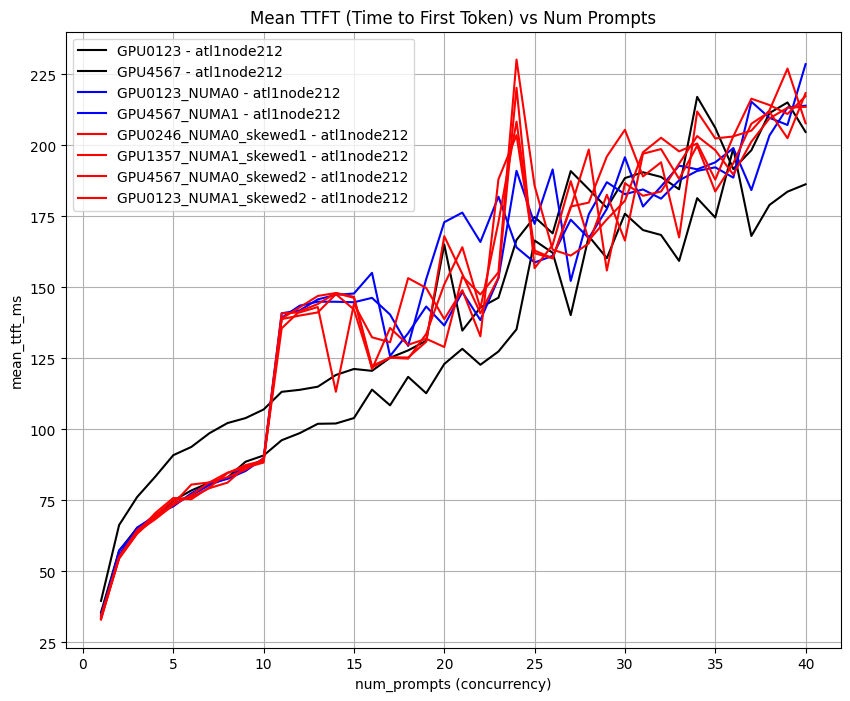

In [98]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["mean_ttft_ms"],
        #temp_df["median_ttft_ms"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("mean_ttft_ms")
plt.title("Mean TTFT (Time to First Token) vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2


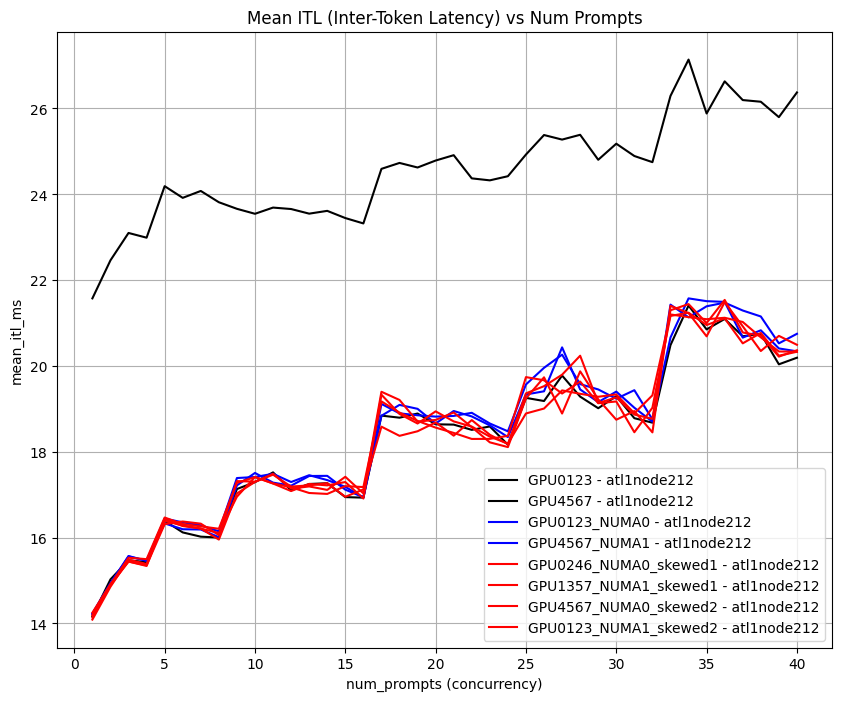

In [99]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["mean_itl_ms"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("mean_itl_ms")
plt.title("Mean ITL (Inter-Token Latency) vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2


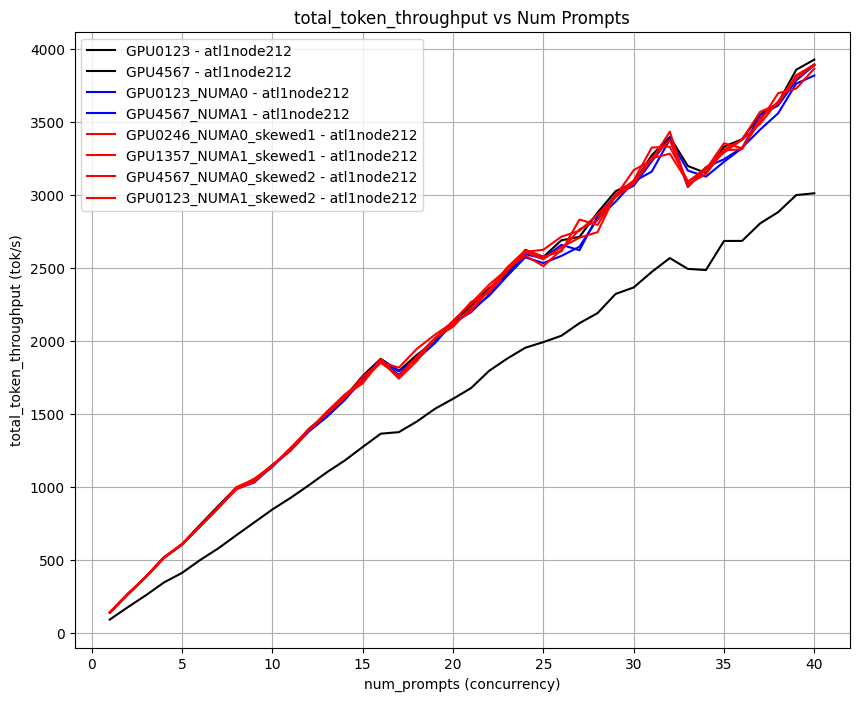

In [100]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["total_token_throughput"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("total_token_throughput (tok/s)")
plt.title("total_token_throughput vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

In [101]:

node_names = [ "atl1node212", "sfo3node1868", "sfo3node1874", "sfo3node1879" ]

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA0
Node: sfo3node1868, Instance: GPU4567_NUMA1
Node: sfo3node1868, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1868, Instance: GPU1357_NUMA1_skewed1
Node: sfo3node1868, Instance: GPU4567_NUMA0_skewed2
Node: sfo3node1868, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA0
Node: sfo3node1874, Instance: GPU4567_NUMA1
Node: sfo3node1874, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1874, Instance: GPU1357_NUMA1_skew

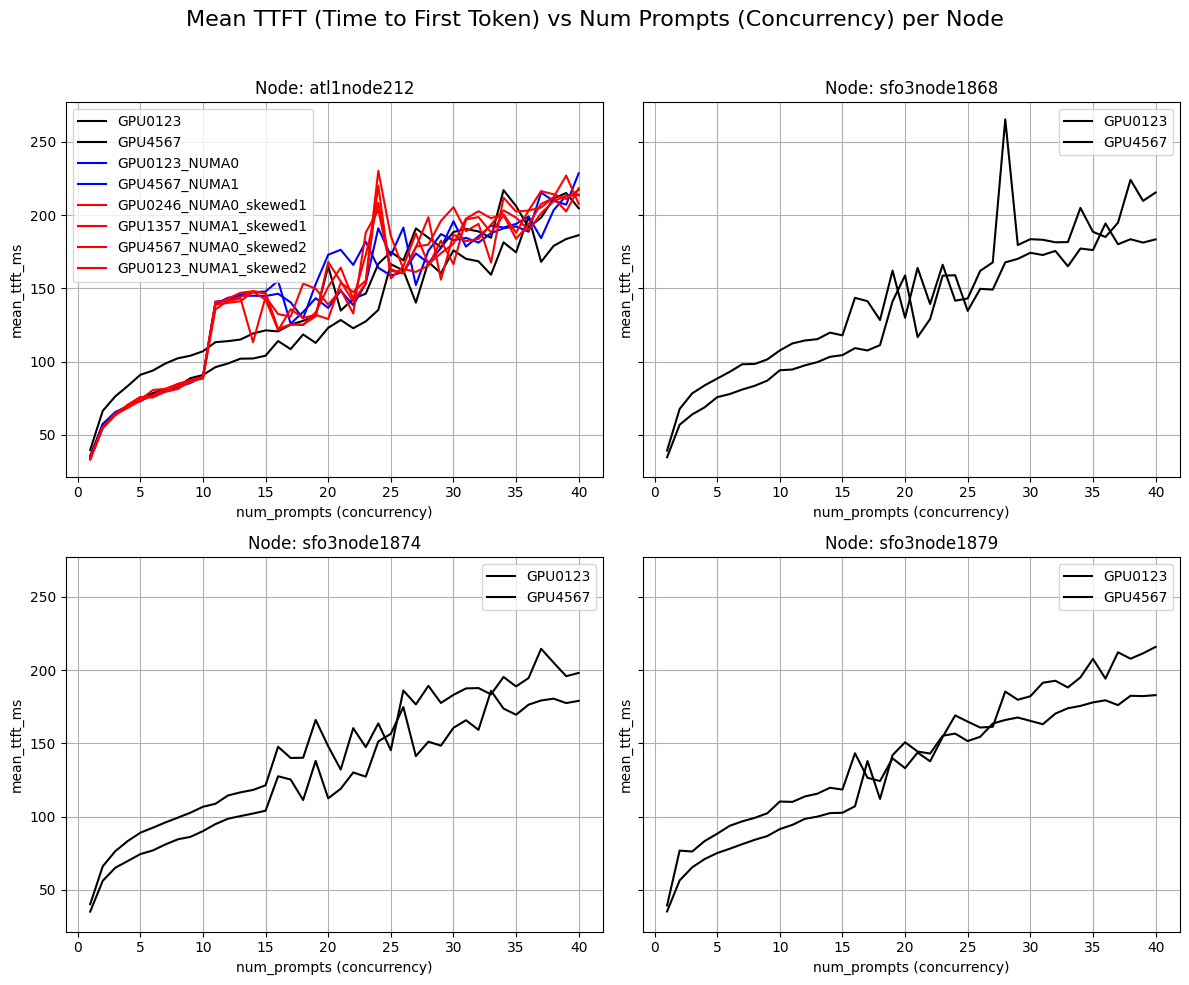

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["mean_ttft_ms"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("mean_ttft_ms")
    ax.grid(True)
    ax.legend()

fig.suptitle("Mean TTFT (Time to First Token) vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA0
Node: sfo3node1868, Instance: GPU4567_NUMA1
Node: sfo3node1868, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1868, Instance: GPU1357_NUMA1_skewed1
Node: sfo3node1868, Instance: GPU4567_NUMA0_skewed2
Node: sfo3node1868, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA0
Node: sfo3node1874, Instance: GPU4567_NUMA1
Node: sfo3node1874, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1874, Instance: GPU1357_NUMA1_skew

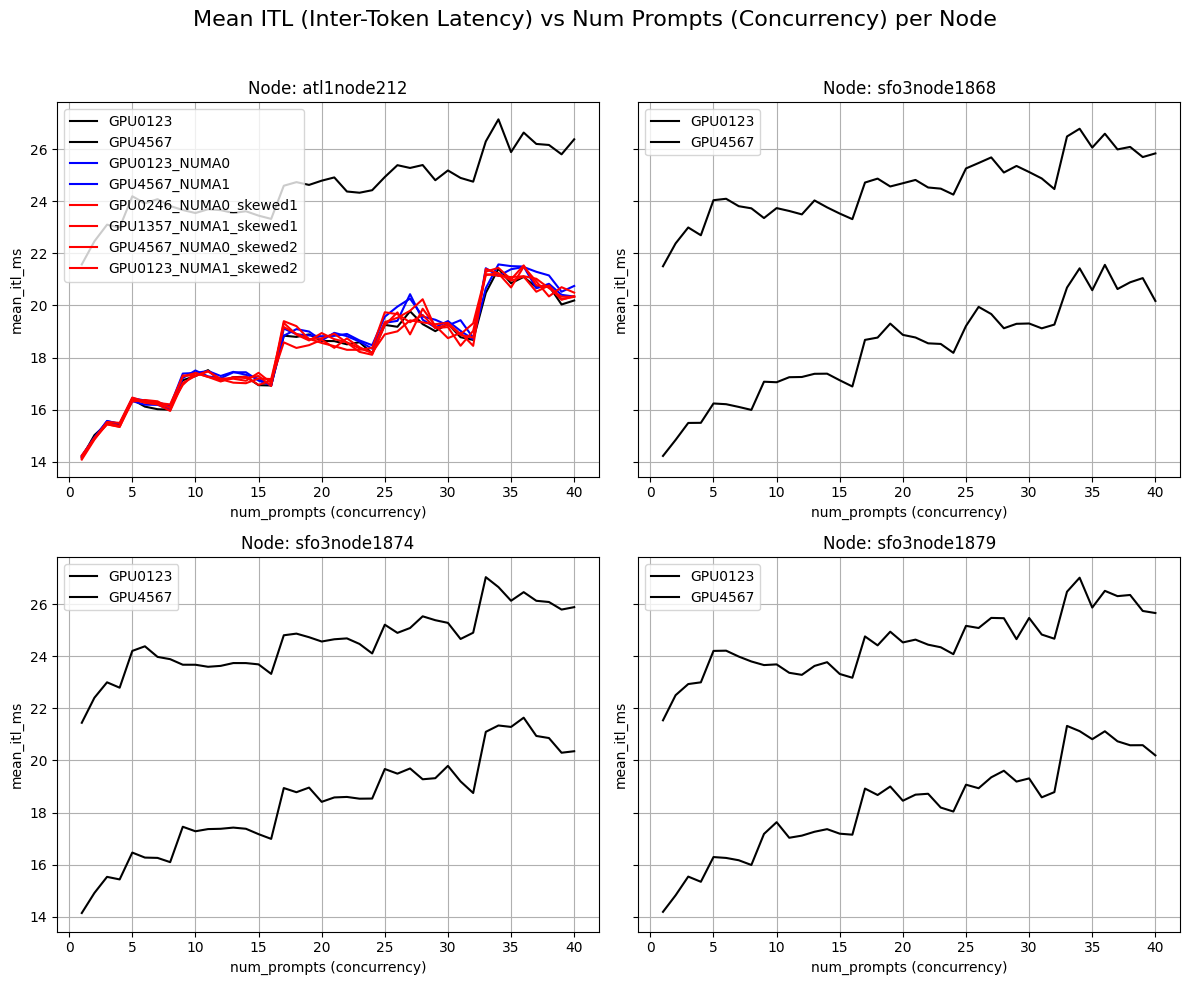

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["mean_itl_ms"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("mean_itl_ms")
    ax.grid(True)
    ax.legend()

fig.suptitle("Mean ITL (Inter-Token Latency) vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA0
Node: atl1node212, Instance: GPU4567_NUMA1
Node: atl1node212, Instance: GPU0246_NUMA0_skewed1
Node: atl1node212, Instance: GPU1357_NUMA1_skewed1
Node: atl1node212, Instance: GPU4567_NUMA0_skewed2
Node: atl1node212, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA0
Node: sfo3node1868, Instance: GPU4567_NUMA1
Node: sfo3node1868, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1868, Instance: GPU1357_NUMA1_skewed1
Node: sfo3node1868, Instance: GPU4567_NUMA0_skewed2
Node: sfo3node1868, Instance: GPU0123_NUMA1_skewed2
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA0
Node: sfo3node1874, Instance: GPU4567_NUMA1
Node: sfo3node1874, Instance: GPU0246_NUMA0_skewed1
Node: sfo3node1874, Instance: GPU1357_NUMA1_skew

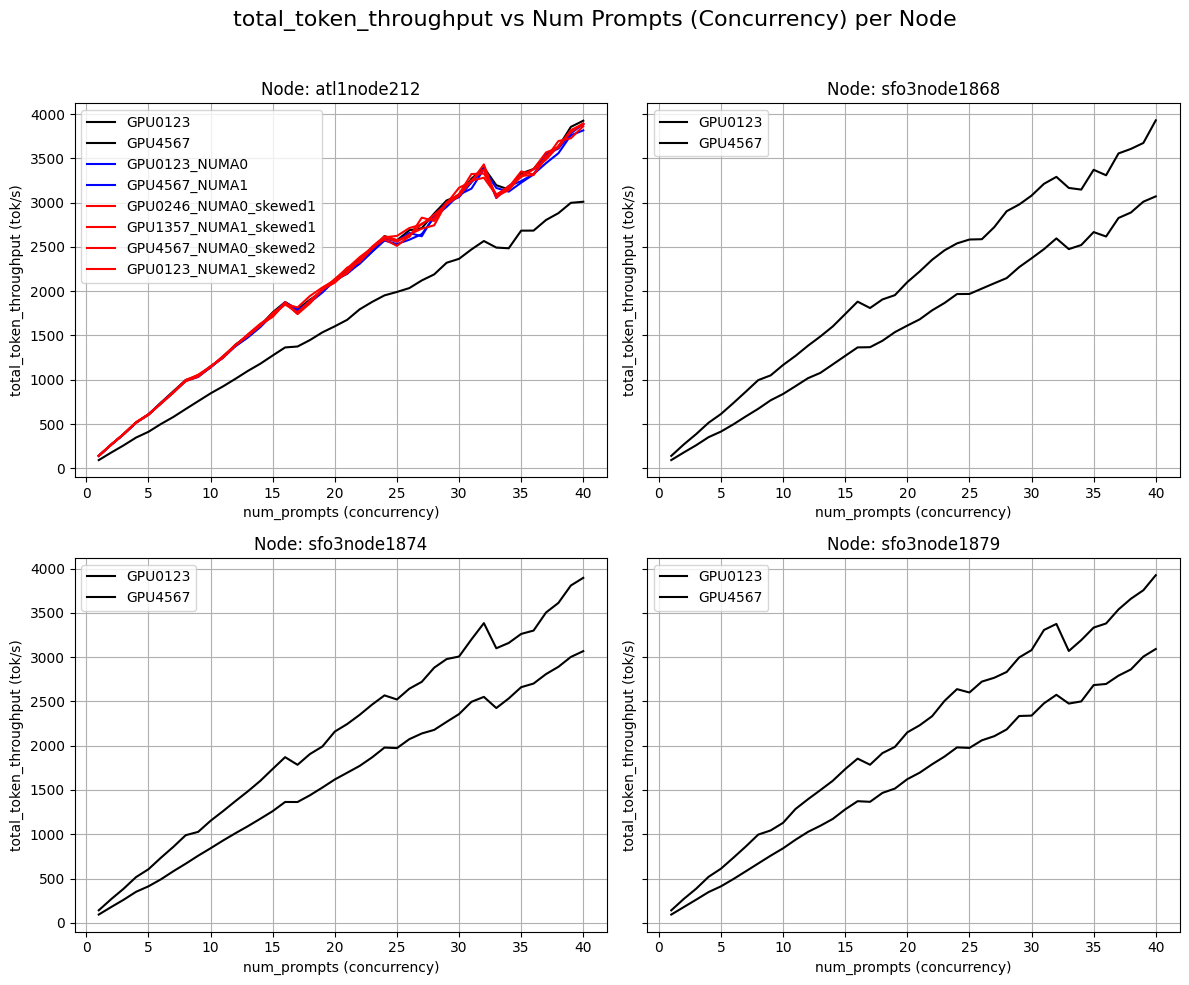

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["total_token_throughput"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("total_token_throughput (tok/s)")
    ax.grid(True)
    ax.legend()

fig.suptitle("total_token_throughput vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()